TL;DR: RNN-training in Theano using Backpropagation through Time (BPTT) can be greatly accelerated by unrolling Theano's built-in loop construct. The speedups were frankly a bit surprising. Therefore I decided to write a short tutorial on this.

### Introduction ###
RNNs have recently drawn much attention due to their successful application to many difficult tasks. There are many great blog posts out there, e.g. [this](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) one, which I found particularly helpful.

I got interested in RNNs a while ago for a research project and found Theano a great tool to learn how to use them.

[Theano](http://deeplearning.net/software/theano/index.html) is an amazing piece of software.
It enables the user to conveniently compose mathematical expressions using a library of pre-defined operations. 
It is mainly used to define differentiable multi-variate real-valued functions that typically arise as objective functions in machine-learning methods. This has the following two major benefits:

- Theano can automatically derive gradients: while specifying the objective function is usually straight-forward, deriving gradients can be a tedious and error-prone task. Since Theano's elementary operations implement partial derivatives, Theano can figure out gradients of compound expressions by applying the chain rule.
- Theano expressions can be executed on different backends, in particular GPUs that can lead to speedups of 1-2 orders of magnitude.

These features make Theano particularly suitable for deep learning, since deep neural networks can be decomposed into linear- and simple non-linear operations, computations that are suitable to be accelerated by GPUs.

In a nutshell, the Theano workflow consists two steps: first we define a Theano expression by symbolically declaring variables and specifying a sequence of operations acting on them. Second, this expression is compiled into a concrete, executable function. At this stage Theano can apply various optimizations due to its global view on the computation to avoid redundancies and unnecessary copies.

#### Preliminaries
In what follows the following version of Theano is used

```python
print theano.version.version
```
    0.8.2.dev-RELEASE
 
The GPU is a NVidia Tesla C2070 with driver version 352.79 and Cuda version 7.5 on Ubuntu 14.04.4 LTS with kernel 3.13.0-79. The GPU has compute capability 2.0 and does not support cuDNN.

The code in this notebook is self-contained and requires the following modules:

In [1]:
import theano
import theano.tensor as T
from numpy import *
from scipy.misc import logsumexp
import time
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
matplotlib.interactive(True)

Using gpu device 0: Tesla C2070 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN not available)


### Recurrent Neural Networks

We would like to model sequences of objects some input space $\mathcal{X}$. Here, we think of $\mathcal{X}$ as a discrete set of size $M$, e.g. representing a vocabulary.
RNNs can be thought of transforming a sequence $x = [x_1, \ldots, x_B], x_t \in \mathcal{X}$ to a sequence of real-valued vectors of dimension $D$, which we will refer to as hidden vectors:

$$
[x_1,\ldots,x_B] \mapsto [{\bf h}_1, \ldots, {\bf h}_B]
$$

The hidden vector ${\bf h}_t$ represents the state of the network after having seen $t$ elements of the sequence.

Popular RNN architectures used today recursively define the computation of a hidden vector ${\bf h}_t$ in terms of the input at time $t$ as well as the previous hidden vector ${\bf h}_{t-1}$:

$$
{\bf h}_t = \mathrm{step}({\bf h}_{t-1}, x_t)
$$

State-of-the-art architectures such as LSTMs and GRUs are instances of this. 
For the purposes of this tutorial however, we will rather focus on the perhaps simplest incarnation, where the recursion is defined as

$$
{\bf a}_t = {\bf W}_h {\bf h}_{t-1} + {\bf W}_i { \delta}_{x_t}
$$

$$
{\bf h}_t = \sigma({\bf a}_t)
$$

${\bf W}_h$ and ${\bf W}_i$ are matrices that parameterize the RNN, and $\delta_{x_t}$ is the one-hot encoding of $x_t$.
$\sigma$ is a point-wise non-linear function, e.g. ```tanh```, logistic sigmoid, or the rectified linear function.
The initial hidden vector ${\bf h}_0$ is given and could be all zeros, a constant vector or even treated as a parameter.

Let's see some code for this.

In [2]:
def stepTemplate(xt, hprev, Wh, Wi, mvm, sigma):
    at = mvm(Wh, hprev) + Wi[xt]
    ht = sigma(at)
    return ht

#numpy version
stepN = lambda x, h, Wh, Wi : stepTemplate(x, h, Wh, Wi, dot, tanh)
#theano version
stepT = lambda x, h, Wh, Wi : stepTemplate(x, h, Wh, Wi, T.dot, T.tanh)

We will start with a more familiar numpy version.
Therefore, the function ```stepN()``` takes the numpy versions for matrix-vector multiplication and the non-linear function, whereas ```stepT()``` takes the theano versions that expect symbolic variables.

### A Generative Model For Sequences
At this stage one may ask what to do with the hidden vectors. One of the strengths of RNNs and neural networks in general is their flexibility. The hidden vectors as a representation or summary of what the network has seen so far can be used in various ways by passing it through an appropriate output layer.
A natural question is to ask after having seen the first $t$ elements of a sequence what a likely $t+1$-th element could be.
This question could be answered if we had a way to specify a distribution over $\mathcal{X}$ given the sequence up to element $t$: $P_t := P(X_{t+1} \mid X_{1},\ldots, X_{t})$.
This would gives us a generative sequence model in the sense that we could sample sequences element by element updating the distribution as we go.
Using the real-valued hidden vector representation, we can define such distributions by reducing it to a standard multi-class logistic regression problem: we can think of ${\bf h}_t$ as a feature vector that we would like to classify as one of the $M$ "classes" in $\mathcal{X}$.
For this, we first multiply the "feature" vector by a weight vector per class, which we will conveniently arrange in a matrix of size $D \times M$:

$$ z_t = {\bf h}_t^T{\bf W}_o $$

Then we exponentiate the resulting vector elementwise and normalize, i.e. pass it through the ```softmax``` function to get a probability vector:

$$P_t = \mathrm{softmax}(z_t)$$

This gives us the tools to specify a likelihood of a set of training sequences that can then be optimized with respect to the model parameters. The parameters here are the matrices ${\bf W}_h, {\bf W}_i$ for the RNN and ${\bf W}_o$ for the output layer.
We obtain the likelihood by taking the value that $P_t$ assigns to element $x_{t+1}$:

$$
l_t = \log P_t(x_{t+1})
$$

This can also be thought of as computing the negative [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy) between the Kronecker delta  $\delta_{x_{t+1}}(\cdot)$ and $P_t$.

We sum up these quantities to obtain the log-likelihood of a sequence. 
Maximizing the log-likelihood initutively gives us parameters that assigns high probability to the sequences in the training set. 
In order to comply with more standard machine learning terminology, we will compute the negative log-likelihood and refer to it as the logistic loss (which we should then be minimized).

First, let's see how we can implement this in numpy:

In [3]:
def rnnN(x, h0, Wh, Wi):
    h = h0
    B,D = len(x), Wh.shape[0]
    H = zeros((B, D)).astype(float32)
    for (t,xt) in enumerate(x):
        h = stepN(xt, h, Wh, Wi)
        H[t] = h
    return H

def logisticLossN(y, H, Wo):
    Z = dot(H, Wo)
    l_t = Z[range(B), y] - logsumexp(Z,1)
    return mean(-l_t)

Here, inputs ```x``` and ```y``` denote the overlapping sub-sequences $[x_1,\ldots, x_{B-1}]$ and $[x_2, \ldots, x_B]$, respectively.

### Theano Implementation
We present the theano implementation top-down, starting with the definition of the loss function. It accepts hidden vectors and the sequence to predict. In addition to the loss, it returns also the symbolic gradients, which is just a matter of a call to [```theano.grad```](http://deeplearning.net/software/theano/tutorial/gradients.html):

In [4]:
def logisticLossT(ty, tH, tParams):
    tY = T.dot(tH, tParams['Wo'])
    tP = T.nnet.softmax(tY)
    tl_t = (T.nnet.categorical_crossentropy(tP, ty))
    tLoss = T.mean(T.nnet.categorical_crossentropy(tP, ty))
    tGrad = {name:theano.grad(tLoss, var) for name, var in tParams.iteritems()}
    return tLoss, tGrad

As mentioned before, symbolic Theano expressions need to be compiled into concrete functions.
This can be achieved by using [```function```](http://deeplearning.net/software/theano/library/compile/function.html).
Here, we chose to define a function that computes the value of the loss for a sequence and at the same time populates a pre-allocated memory region (so called [shared variables](http://deeplearning.net/software/theano/library/compile/shared.html)) with the values of the gradients. This has the benefit of potentially avoiding transfers to and from the GPU.

The ```compileLoss``` function accepts a parameter dictionary that maps parameter names to sizes and a function that returns a Theano expression for the computation of the hidden vectors. The parameter dictionary should look like this:
```python
params = {'Wh':(D,D), 'Wi':(M,D), 'Wo':(D,M)}
```
What remains is to describe the different ways to specify the ```rnnLayer``` function.

In [5]:
def getSharedGrad(params):
    return {n: theano.shared(zeros(params[n], dtype=float32),'sg'+n) for n in params}

def compileLoss(params, rnnLayer):
    #0. symbolic variables
    tParams = {name : T.matrix(name) for name in params}
    th0 = T.vector()
    tx = T.ivector()
    ty = T.ivector()
    #1. allocate shared memory for gradients
    shGrad = getSharedGrad(params)
    #2. allocate shared memory for hidden vectors
    sH = theano.shared(zeros((B, D)).astype(float32))
    #3. symbolic hidden vectors
    tH = rnnLayer(tx, th0, tParams)
    #4. loss
    tLoss, tGrad = logisticLossT(ty, tH, tParams)
    #5. register updates for shared variables 
    updates = [(shGrad[name], tGrad[name]) for name in tParams]
    updates.append( (sH, tH) )
    #6. define inputs
    inputs = [tx, ty, th0, tParams['Wh'], tParams['Wi'], tParams['Wo']]
    #7. compile the function
    loss = theano.function(inputs=inputs, outputs=tLoss, updates=updates)
    return loss, sH, shGrad

### Unrolling Loops in Theano
Loops in Theano are typically realized using the [```scan```](http://deeplearning.net/software/theano/library/scan.html) operator. 
My first attempt at implementing RNNs using scan resulted in somewhat slow code, which I tried to optimize.
I read somewhere that unrolling ```scan``` might help, but at first did not understand how to do it.
The following code represents my current understanding which I wanted to share as I was quite happy with the speedups I achieved.

The first version uses scan to which we pass the rnn step function (```fn```), the initial hidden vector (```outputs_info```), the input sequence to iterate over (```sequences```) and static parameters (```non_sequences```).

In [6]:
def rnnT_scan(tx, th0, tParams):
    nonSeqs = [tParams['Wh'], tParams['Wi']]
    tH, _ = theano.scan(fn = stepT, outputs_info=[th0], sequences=[tx], non_sequences=nonSeqs)
    return tH

The unrolled equivalent below is different in mainly two aspects: first, the length of the sequence has to be known, while the version above takes a symbolic sequence whose length can be unknown at compile time. Second, in every iteration we explicitely create new symbolic variables that Theano needs to process at compile time. This will have an impact on the compilation time as we will see later.

In [7]:
def rnnT_unroll(tx, th0, tParams, B):
    th = th0
    tH_tmp = []
    for t in xrange(B):
        th = stepT(tx[t], th, tParams['Wh'], tParams['Wi'])
        tH_tmp.append(th)
    return T.stack(tH_tmp)

### Running-Time Comparison
The code below compares the scan version to the unrolled version in terms of compile time and running time for small and large values of $M$ and different sequence lengths. $D$ is fixed and the parameter matrices are initialized randomly.


In [8]:
random.seed(20160825)

D = 128

Ms = [pow(2, k) for k in [8,16]]
Bs = [32,64,128]

cts_sc = zeros((len(Ms), len(Bs)))
rts_sc = zeros((len(Ms), len(Bs)))

cts_ur = zeros((len(Ms), len(Bs)))
rts_ur = zeros((len(Ms), len(Bs)))

def initParams(D, params):
    h0 = random.rand(D).astype(float32) 
    p0 = {n:random.randn(*d).astype(float32) / sqrt(D) for n, d in params.iteritems()}
    return h0, p0

def genSequence(B, M):
    seq = random.randint(0, M, B+1).astype(int32)
    x = seq[:-1]
    y = seq[1:]
    return x, y 

def relErr(X,Y):
    return linalg.norm(X-Y, inf) / linalg.norm(X,inf)

for m, M in enumerate(Ms):
    for b, B in enumerate(Bs):
        x, y = genSequence(B,M)
        params = {'Wh':(D,D), 'Wi':(M,D), 'Wo':(D,M)}
        h0, p0 = initParams(D,params)
        rnn_ur = lambda x,h,p: rnnT_unroll(x,h,p,B)
        
        loss_ur, sH_ur, shGrad_ur = compileLoss(params, rnn_ur)
        t = %timeit -o -q -r3 compileLoss(params, rnn_ur)
        cts_ur[m,b] = t.best
        t = %timeit -o -q -r3 loss_ur(x,y,h0,p0['Wh'],p0['Wi'],p0['Wo'])
        rts_ur[m,b] = t.best
        
        loss_sc, sH_sc, shGrad_sc = compileLoss(params, rnnT_scan)
        t = %timeit -o -q -r3 compileLoss(params, rnnT_scan)
        cts_sc[m,b] = t.best
        t = %timeit -o -q -r3 loss_sc(x,y,h0,p0['Wh'],p0['Wi'],p0['Wo'])
        rts_sc[m,b] = t.best
        
        assert(all([relErr(shGrad_sc[name].get_value(),
                           shGrad_ur[name].get_value()) 
                    < 1e-6 for name in params])) 

The following code generates the plots below.

In [9]:
def myplot(d1, d2, titles, legend, xlab, ylab, ylog = False):
    width = 0.3
    binpos = arange(len(Bs))
    fig, axs = plt.subplots(1,d1.shape[0])
    for it, ax in enumerate(axs):
        ax.bar(binpos, d1[it,:], width, color='blue', lw=0)
        ax.bar(binpos+0.4, d2[it,:], width, color='darkgoldenrod', lw=0)
        plt.setp(ax, xticks=binpos+width+0.05, xticklabels=Bs,xlim=[-0.1,2.8],
                     title=titles[it],xlabel=xlab,ylabel=ylab)
        ax.grid(True)
        ax.legend(legend, loc=2, frameon=True)
        if ylog: ax.set_yscale('log')
    plt.tight_layout()
    
titles = ["$M=256$", "$M=65536$"]
legend = ["Unrolled", "scan"]
xlab = 'Seq. Length'
ylab = 'Time(sec)'

### Results 

#### Running Time
The plots below compare the running time of the two RNN implementations for three different sequence lengths.
For a relatively small value of $M$ both implementations are relatively close.
In some applications however, the size of the input space can easily be on the order of $10^5$, e.g. sequences of words of documents in large corpora of text. For a larger value of $M$ we see that the unrolled version is much faster.
Checking the Theano profiler also indicates that scan is the culprit.
I am still trying to figure out, why this is the case.

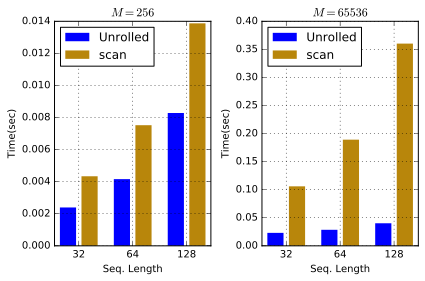

In [10]:
myplot(rts_ur, rts_sc, titles, legend, xlab, ylab)

#### Compile Time
The downside of unrolling is the increase in compile time illustrtated below, which is actually quite dramatic (note the log scale of the y-axis).
As expected, the scaling does not depend on the input size, i.e. $M$, but rather on the length of the sequence for the unrolled implementation, in contrast to the scan version which is agnostic to the sequence length at compile time.
This can certainly be a nuisance while prototyping, but a minor price to pay in the light of the gains in execution time demonstrated above. Furthermore, the impact of the compile time can be to an extent further reduced by precompiling and pickling Theano expressions.

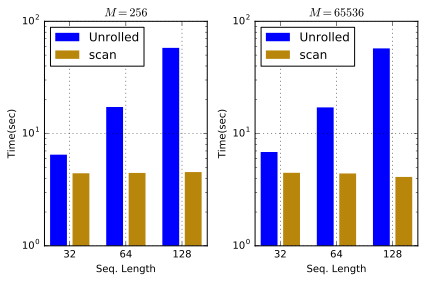

In [11]:
myplot(cts_ur, cts_sc, titles, legend, xlab, ylab, True)

### Conclusion
I find the scaling behaviour a bit suspicious and do not rule out a mistake in the configuration. I was, however, able to reproduce it on another machine where I could install newer software and drivers.
For me, avoiding the use of scan was a viable solution to get the job done, but it would be great to better understand the cause of this discrepancy. I hope this tutorial is useful for someone getting started with RNNs in Theano and would appreciate any pointers to better understand this issue.